# Coffea package

In [37]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
plt.style.use(hep.style.CMS)

In [2]:
import yaml
with open("datasets.yaml") as f:
    datasets = yaml.safe_load(f)

# NanoEvents

NanoEvents is a Coffea utility to wrap flat nTuple structures (such as the CMS NanoAOD format) into a single awkward array with appropriate object methods (such as Lorentz vector methods), cross references, and nested objects, all lazily accessed from the source ROOT TTree via uproot. The interpretation of the TTree data is configurable via schema objects, which are community-supplied for various source file types. These schema objects allow a richer interpretation of the file contents than the uproot.lazy methods. Currently available schemas include:

In [3]:
events = NanoEventsFactory.from_root(
    datasets['DYJetsToLL']['files'][0],
    schemaclass=NanoAODSchema.v7,
    metadata={"dataset": "DYJets"},
    entry_stop = 5000
).events()


In [4]:
events

<NanoEventsArray [<event 1:155:385003>, ... ] type='5000 * event'>

In [5]:
events.Jet

<JetArray [[], [Jet, Jet, ... Jet, Jet, Jet, Jet]] type='5000 * var * jet'>

Now the fields of the various object collections are grouped under specific awkward records, such as `Jet`, `Electron` etc

In [6]:
events.fields

['SV',
 'genTtbarId',
 'HLT',
 'Muon',
 'SoftActivityJetNjets10',
 'PuppiMET',
 'SoftActivityJet',
 'SoftActivityJetHT',
 'RawMET',
 'LHE',
 'TrigObj',
 'Photon',
 'SoftActivityJetHT2',
 'ChsMET',
 'L1Reco',
 'Jet',
 'fixedGridRhoFastjetCentralChargedPileUp',
 'LHEReweightingWeight',
 'DeepMETResponseTune',
 'Electron',
 'SubGenJetAK8',
 'boostedTau',
 'L1simulation',
 'LHEWeight',
 'CaloMET',
 'OtherPV',
 'genWeight',
 'GenJet',
 'event',
 'LHEScaleWeight',
 'Generator',
 'HLTriggerFinalPath',
 'PV',
 'luminosityBlock',
 'Tau',
 'L1PreFiringWeight',
 'Pileup',
 'MET',
 'GenIsolatedPhoton',
 'run',
 'LHEPart',
 'btagWeight',
 'SoftActivityJetNjets2',
 'HLTriggerFirstPath',
 'fixedGridRhoFastjetAll',
 'SoftActivityJetHT5',
 'TkMET',
 'fixedGridRhoFastjetCentral',
 'FsrPhoton',
 'GenVisTau',
 'GenMET',
 'SubJet',
 'GenPart',
 'LowPtElectron',
 'IsoTrack',
 'LHEPdfWeight',
 'fixedGridRhoFastjetCentralCalo',
 'Flag',
 'RawPuppiMET',
 'SoftActivityJetHT10',
 'GenJetAK8',
 'FatJet',
 'SoftAc

In [7]:
events.Jet.fields

['area',
 'btagCSVV2',
 'btagDeepB',
 'btagDeepCvB',
 'btagDeepCvL',
 'btagDeepFlavB',
 'btagDeepFlavCvB',
 'btagDeepFlavCvL',
 'btagDeepFlavQG',
 'chEmEF',
 'chFPV0EF',
 'chHEF',
 'eta',
 'hfsigmaEtaEta',
 'hfsigmaPhiPhi',
 'mass',
 'muEF',
 'muonSubtrFactor',
 'neEmEF',
 'neHEF',
 'phi',
 'pt',
 'puIdDisc',
 'qgl',
 'rawFactor',
 'bRegCorr',
 'bRegRes',
 'cRegCorr',
 'cRegRes',
 'electronIdx1',
 'electronIdx2',
 'hfadjacentEtaStripsSize',
 'hfcentralEtaStripSize',
 'jetId',
 'muonIdx1',
 'muonIdx2',
 'nElectrons',
 'nMuons',
 'puId',
 'nConstituents',
 'genJetIdx',
 'hadronFlavour',
 'partonFlavour',
 'cleanmask',
 'electronIdx1G',
 'electronIdx2G',
 'genJetIdxG',
 'muonIdx1G',
 'muonIdx2G',
 'muonIdxG',
 'electronIdxG']

# Cross-references
The NanoEvents schema is able to read the CMS NanoAOD format and it's cross-references indices. 


In [19]:
events.Electron.matched_gen

<GenParticleArray [[], [], [], ... GenParticle, None], []] type='4410 * var * ?g...'>

For example: The tree of GenParticles decays can be easily explored

In [23]:
events.GenPart.children

<GenParticleArray [[[GenParticle], [], ... [], []]] type='4410 * var * var * ?ge...'>

In [27]:
print(f"Raw status flags: {events.GenPart.statusFlags}")
events.GenPart.hasFlags(['isPrompt', 'isLastCopy'])

Raw status flags: [[14721, 10625, 4481, 257, 257, 257, ... 12354, 12352, 12352, 12354, 12354, 12354]]


<Array [[True, True, False, ... False, False]] type='4410 * var * bool'>

In [28]:
events.GenPart[
    (abs(events.GenPart.pdgId) == 11)
    & events.GenPart.hasFlags(['isPrompt', 'isLastCopy'])
].distinctParent.pdgId

<Array [[], [], [], [], ... [], [23, 23], []] type='4410 * var * ?int32[paramete...'>

## Vector behaviour

In [8]:
mask_2j = ak.num(events.Jet, axis=1)>=2
events = events[mask_2j]

For example: We can compute the deltaR between the leading jet and another collection

In [10]:
dr = events.Jet[:, 0].delta_r(events.Electron)
dr

<Array [[], [], [], ... 3.02, 2.61, 2.89], []] type='4410 * var * float32'>

We can build new candidated by summing other vectors --> the data is interpreted as 4-momentum vectors

In [24]:
dijet = events.Jet[:,0] + events.Jet[:,1]

For example we can get the mass of the new particle

Text(1, 0, 'dijet mass')

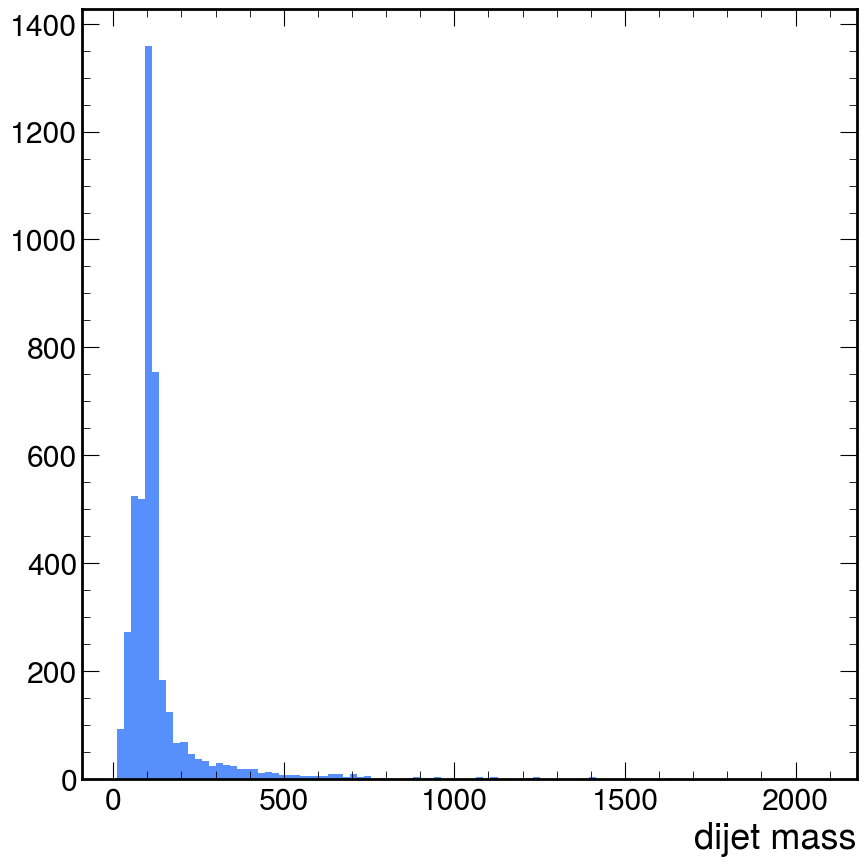

In [29]:
plt.hist(dijet.mass, bins=100);
plt.xlabel("dijet mass")

# Weights

Coffea provides an improved interface to the interpretation of TTrees data formats (specifically for CMS NanoAODs, but other formats are available or under developement, e.g. for ATLAS). Moreover Coffea provides a set of analsysi tools for handling Weights, systematics variation, and cuts.



In [64]:
from coffea.analysis_tools import Weights

Nevents = len(events)
weights = Weights(Nevents)

In [65]:
weights.add("SF1", np.random.sample((Nevents)))

In [56]:
weights.weight()

array([0.60349645, 0.50648762, 0.47367758, ..., 0.27911608, 0.42000259,
       0.15701576])

In [57]:
weights.add?

Signature: weights.add(name, weight, weightUp=None, weightDown=None, shift=False)
Docstring:
Add a new weight

Adds a named correction to the event weight, and optionally also associated
systematic uncertainties.

Parameters
----------
    name : str
        name of correction
    weight : numpy.ndarray
        the nominal event weight associated with the correction
    weightUp : numpy.ndarray, optional
        weight with correction uncertainty shifted up (if available)
    weightDown : numpy.ndarray, optional
        weight with correction uncertainty shifted down. If ``weightUp`` is supplied, and
        the correction uncertainty is symmetric, this can be set to None to auto-calculate
        the down shift as ``1 / weightUp``.
    shift : bool, optional
        if True, interpret weightUp and weightDown as a realtive difference (additive) to the
        nominal value

.. note:: ``weightUp`` and ``weightDown`` are assumed to be rvalue-like and may be modified in-place by this func

Let's now add multilple weights. 

If we want to be able to access the single weights we need to specify `storeIndividual=True`, but we will pay a cost in memory. 
By default all the weights are accumulated in a single vector when added.

In [101]:
weights = Weights(Nevents, storeIndividual=True)
weights.add("SF1", 2.*np.ones(Nevents), 
            weightUp=5.*np.ones(Nevents), 
            weightDown=0.5*np.ones(Nevents))

In [102]:
weights.variations

{'SF1Down', 'SF1Up'}

In [103]:
weights.weight()

array([2., 2., 2., ..., 2., 2., 2.])

In [104]:
weights.weight(modifier="SF1Down")

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

In [105]:
weights.weight(modifier="SF1Up")

array([5., 5., 5., ..., 5., 5., 5.])

In [106]:
weights.add("SF2", 3.*np.ones(Nevents), 
            weightUp=6.*np.ones(Nevents), 
            weightDown=0.2*np.ones(Nevents))

In [107]:
weights.weight()

array([6., 6., 6., ..., 6., 6., 6.])

In [108]:
weights.partial_weight(include=["SF1"])

array([2., 2., 2., ..., 2., 2., 2.])

In [109]:
weights.variations

{'SF1Down', 'SF1Up', 'SF2Down', 'SF2Up'}

In [110]:
weights.weight(modifier="SF1Up")

array([15., 15., 15., ..., 15., 15., 15.])

In [111]:
weights.weight(modifier="SF2Up")

array([12., 12., 12., ..., 12., 12., 12.])

#### Weights with multiple possible variations

In [114]:
weights = Weights(Nevents)

weights.add_multivariation("SF1", 
            weight=2.*np.ones(Nevents), 
            modifierNames=["stat", "syst"],
            weightsUp=[5.*np.ones(Nevents), 3.*np.ones(Nevents)],
            weightsDown=[0.5*np.ones(Nevents), 0.3*np.ones(Nevents)]
           )

In [115]:
weights.variations

{'SF1_statDown', 'SF1_statUp', 'SF1_systDown', 'SF1_systUp'}

# Cuts

# Applying corrections

# Processors

# Scale up

# Exercise